<a href="https://colab.research.google.com/github/catastropiyush/Ramachandran_Plotter/blob/main/Ramachandran_Plotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/catastropiyush/Ramachandran_Plotter.git

Cloning into 'Ramachandran_Plotter'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 194 (delta 4), reused 8 (delta 4), pack-reused 181 (from 1)
Receiving objects: 100% (194/194), 78.14 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [3]:
!pip install  scipy biopython matplotlib argparse opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.5 MB/s eta 0:00:00


In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [19]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [20]:
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [4]:
try:
  import py3Dmol
except:
  !pip install py3Dmol
  import py3Dmol

In [ ]:
try:
  import prody
except:
  !pip install -U prody
  import prody

https://colab.research.google.com/github/daveminh/Chem456-2022F/blob/main/exercises/02-structural_visualization.ipynb#scrollTo=S2GfVk67gisv

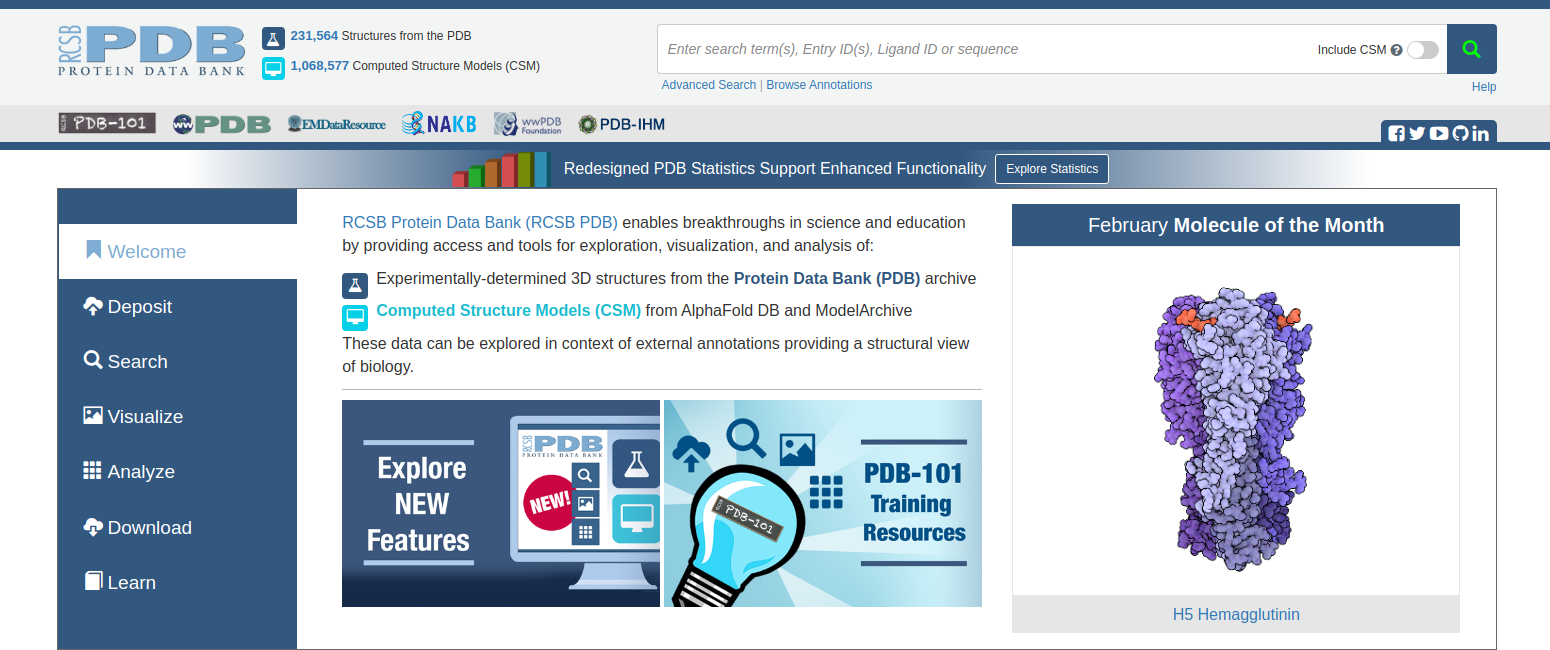

https://www.google.com/url?q=https%3A%2F%2Fwww.rcsb.org%2F

In [6]:
PDB_5rh2 = prody.parsePDB('5rh2')
!gunzip 5rh2.pdb.gz

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> Downloading PDB files via FTP failed, trying HTTP.
INFO:.prody:Downloading PDB files via FTP failed, trying HTTP.
@> 5rh2 downloaded (5rh2.pdb.gz)
DEBUG:.prody:5rh2 downloaded (5rh2.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via HTTP completed (1 downloaded, 0 failed).
@> 2651 atoms and 1 coordinate set(s) were parsed in 0.05s.
DEBUG:.prody:2651 atoms and 1 coordinate set(s) were parsed in 0.05s.


In [36]:
%%writefile /content/Ramachandran_Plotter/RamachandranPlotter.py
"""
    Original author: Joseph I. J. Ellaway
    Modified for Colab
"""

import os
import matplotlib.pyplot as plt
import pandas as pd

# Package functions
from DihedralCalculator import *
from PlotterFunctions import *
from RamaArgumentParser import *

# Main function
def main(pdb, itmod=False, model_num=1, itchain=False, chain_num='A',
         plot_type=0, out_dir='/content', verb=True, save=False, file_type='png'):

    ########################################################
    #               IMPORTING USER DATA                      #

    VerboseStatement(verb, str("Importing " + str(pdb)) )

    userpdb_df = ExtractDihedrals(pdb_file_name=pdb, iter_models=itmod,
                    model_number=model_num, iter_chains=itchain, chain_id=chain_num)
    # Remove invalid dihedral angles/angles from ligands or non-canonical residues
    userpdb_df = userpdb_df.dropna()

    # Selecting user's desired Ramachandran plot
    options = ["All", "General", "Glycine", "Proline", "Pre-proline", "Ile-Val"]
    plot_type = options[int(plot_type)]
    plot_name = os.path.join(out_dir, f'{os.path.splitext(os.path.basename(pdb))[0]}_{plot_type}RamachandranPlot_tmp')

    ########################################################
    #               IMPORTING REFERENCE DATA                 #

    VerboseStatement(verb, "Importing Top8000 library")

    # Top8000 peptide dataset path adjusted for Colab
    top8000_path = "/content/Ramachandran_Plotter/Top8000_DihedralAngles.csv.gz"
    if not os.path.exists(top8000_path):
        raise FileNotFoundError(f"Top8000 dataset not found at {top8000_path}")

    top8000_df = SelectAngles(pd.read_csv(top8000_path, compression="gzip"), plot_type)

    ########################################################
    #               SELECTING RESIDUE TYPE DATA             #

    if plot_type != "All":
        userpdb_df = userpdb_df.loc[userpdb_df["type"] == plot_type]

    ########################################################
    #               SAVING USER DATA (optional)             #

    if save:
        csv_file_name = f"{plot_name[:-4]}.csv"
        VerboseStatement(verb, f"Saving CSV as: {csv_file_name}")
        userpdb_df.to_csv(csv_file_name, index=False)

    VerboseStatement(verb, "Dihedral angles calculated")

    ########################################################
    #                   PLOTTING DATA                       #

    # Plotting parameters
    figure_size = (8,8)
    contour_level_inner = 96
    contour_level_outer = 15
    contour_line_color_inner = "#DFF8FB"
    contour_line_color_outer = "#045E93"
    out_resolution = 96
    data_point_colour = "#D4AB2D"
    data_point_edge_colour = "#3c3c3c"
    background_colour = "Blues"

    VerboseStatement(verb, "Generating background of favoured regions")

    # Ensure output directory exists
    os.makedirs(out_dir, exist_ok=True)

    MakeBackground(top8000_df, plot_type, plot_name, background_colour)

    VerboseStatement(verb, "Plotting Ramachandran diagram")

    plt.style.use("seaborn-v0_8-poster")

    fig, ax = plt.subplots(1,1, figsize=figure_size, tight_layout=True)

    AddContour(ax, top8000_df, contour_level=contour_level_inner, line_colour=contour_line_color_inner)
    AddContour(ax, top8000_df, contour_level=contour_level_outer, line_colour=contour_line_color_outer, contour_alpha=0.3)

    temp_png = f"{plot_name}.png"
    if not os.path.exists(temp_png):
        raise FileNotFoundError(f"Background image not generated at {temp_png}")

    ax.imshow(plt.imread(temp_png), extent=[-195, 195, -195, 195], zorder=1)

    AddGridLines(ax)

    ax.scatter(userpdb_df["phi"], userpdb_df["psi"], s=20, color=data_point_colour,
                            zorder=4, linewidths=0.5, edgecolor=data_point_edge_colour)

    FormatAxis(ax)

    VerboseStatement(verb, "Saving plot")

    output_file = f"{plot_name[:-4]}.{file_type}"
    if file_type == "png":
        plt.savefig(output_file, dpi=out_resolution, bbox_inches='tight')
    else:
        plt.savefig(output_file, bbox_inches='tight')

    # Clean up temporary files
    if os.path.exists(temp_png):
        os.remove(temp_png)

    plt.close()

    print(f"Done.\nRamachandran plot saved to {output_file}")

if __name__ == "__main__":
    # Loading user's input arguments
    pdb, itmod, model_num, itchain, chain_num, plot_type, out_dir, verb, save, file_type = CollctUserArgs()
    main(pdb, itmod, model_num, itchain, chain_num, plot_type, out_dir, verb, save, file_type)

Overwriting /content/Ramachandran_Plotter/RamachandranPlotter.py


In [37]:
!python /content/Ramachandran_Plotter/RamachandranPlotter.py --pdb /content/5rh2.pdb

Done.
Ramachandran plot saved to ./5rh2_AllRamachandranPlot.png


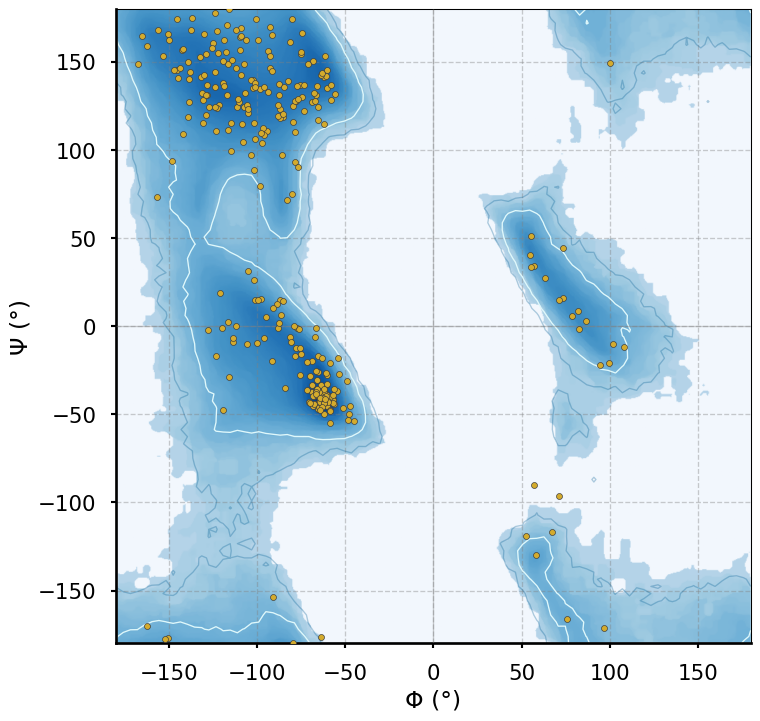

In [38]:
from IPython.display import Image
Image('./5rh2_AllRamachandranPlot.png')

In [17]:
view = py3Dmol.view()
view.addModel(open('5rh2.pdb', 'r').read(),'pdb')
view.setBackgroundColor('white')
view.setStyle({'chain':'A'}, {'cartoon': {'color':'purple'}})
view.addStyle({'resn':'UH7'}, {'stick': {'colorscheme':'yellowCarbon'}})
view.addStyle({'within':{'distance':'8', 'sel':{'resn':'UH7'}}}, {'stick': {}})
view.addLabel("H41",{'fontOpacity':1},{'resi':'41'})
view.addLabel("CYS145",{'fontOpacity':1},{'resi':'145'})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

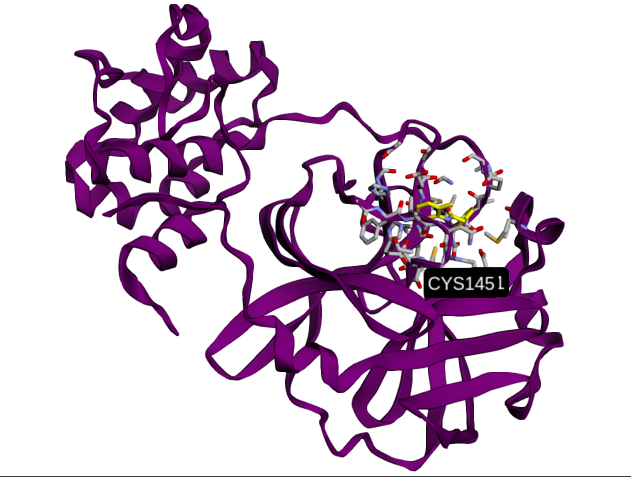

In [42]:
with open("5rh2.pdb") as ifile:
    system = "".join([x for x in ifile])

In [43]:
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

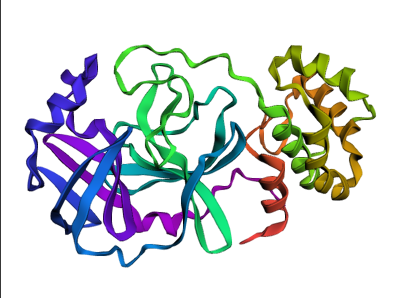

In [32]:
PDB_5rh2 = prody.parsePDB('1crn')
!gunzip 1crn.pdb.gz

@> Connecting wwPDB FTP server RCSB PDB (USA).
DEBUG:.prody:Connecting wwPDB FTP server RCSB PDB (USA).
@> Downloading PDB files via FTP failed, trying HTTP.
INFO:.prody:Downloading PDB files via FTP failed, trying HTTP.
@> 1crn downloaded (1crn.pdb.gz)
DEBUG:.prody:1crn downloaded (1crn.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
DEBUG:.prody:PDB download via HTTP completed (1 downloaded, 0 failed).
@> 327 atoms and 1 coordinate set(s) were parsed in 0.01s.
DEBUG:.prody:327 atoms and 1 coordinate set(s) were parsed in 0.01s.


https://william-dawson.github.io/using-py3dmol.html

In [33]:
with open("1crn.pdb") as ifile:
    system = "".join([x for x in ifile])

In [34]:
view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(system)
view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [39]:
!python /content/Ramachandran_Plotter/RamachandranPlotter.py --pdb /content/1crn.pdb

Done.
Ramachandran plot saved to ./1crn_AllRamachandranPlot.png


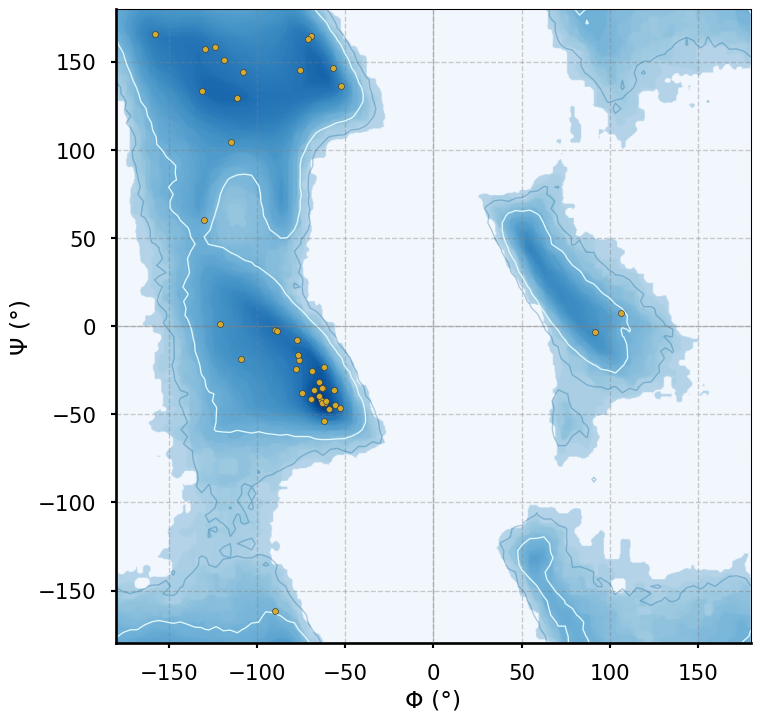

In [41]:
from IPython.display import Image
Image('./1crn_AllRamachandranPlot.png')

In [12]:
import os

def print_directory_structure(rootdir):
    for dirpath, dirnames, filenames in os.walk(rootdir):
        level = dirpath.replace(rootdir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(dirpath)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in filenames:
            print(f'{subindent}{f}')

print_directory_structure('/content')


content/
    5rh2.pdb
    pdb1fat.ent
    .config/
        config_sentinel
        default_configs.db
        .last_update_check.json
        gce
        active_config
        hidden_gcloud_config_universe_descriptor_data_cache_configs.db
        .last_survey_prompt.yaml
        .last_opt_in_prompt.yaml
        logs/
            2025.02.14/
                14.22.04.993255.log
                14.21.23.850793.log
                14.21.54.674849.log
                14.21.56.299216.log
                14.21.45.787287.log
                14.22.05.693568.log
        configurations/
            config_default
    Ramachandran_Plotter/
        DihedralCalculator.py
        RamachandranPlotter.py
        README.md
        RamaArgumentParser.py
        PlotterFunctions.py
        LICENSE
        Top8000_DihedralAngles.csv.gz
        .github/
            ISSUE_TEMPLATE/
                feature_request.md
                bug_report.md
        .git/
            index
            packed-refs
       